In [1]:
import sys
import os
sys.path.append(os.path.join(r'D:\e-commerce_env\e-commerce\Lib\site-packages'))
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv',encoding= 'unicode_escape')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df['StockCode'].value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

In [2]:
def transform_datatypes_and_nulls(df):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['CustomerID'].fillna(0,inplace=True)
    df['CustomerID'] = df['CustomerID'].astype(int)
    df['Quantity'] = df['Quantity'].astype(int)

def fill_null_values_in_descripctions(df):
    # Sort the DataFrame by 'StockCode' and 'InvoiceDate' to ensure rows with the same 'StockCode' are consecutive
    df.sort_values(by=['StockCode', 'InvoiceDate'], inplace=True)
    # Use forward-fill (ffill) to replace null values in 'Description' column
    df['Description'].fillna(method='ffill', inplace=True)
    
# all transactions which weren't normal orders, rather some fee payments etc.
def divide_uncommon_transactions(df):
    df_M = df[df['StockCode'] == 'M']
    df_DOT = df[df['StockCode'] == 'DOT']
    df_BANK_CHARGES = df[df['StockCode'] == 'BANK CHARGES']
    df_AMAZONFEE = df[df['StockCode'] == 'AMAZONFEE']
    df_BAD_DEBT = df[df['StockCode'] == "B"]
    df_POSTAGE = df[df['StockCode'] == "POST"]
    df_DISCOUNT = df[df['StockCode'] == "D"]
    df_CRUK_COMMISIONS = df[df['StockCode'] == "CRUK"]

    return {
        'M': df_M,
        'DOT': df_DOT,
        'BANK CHARGES': df_BANK_CHARGES,
        'AMAZONFEE': df_AMAZONFEE,
        'B': df_BAD_DEBT,
        'POST': df_POSTAGE,
        'D': df_DISCOUNT,
        'CRUK': df_CRUK_COMMISIONS
    }

def create_filtered_orders(df):
    mask = (df['StockCode'] != "AMAZONFEE") & (df['StockCode'] != "BANK CHARGES") & (df['StockCode'] != "M") & (df['StockCode'] != "DOT") & (df['StockCode'] != "B")& (df['StockCode'] != "POST") & (df['StockCode'] != "D") &(df['StockCode'] != "CRUK")
    filtered_df = df[mask]
    return filtered_df

# checking for all canceled orders 
def cancelled_orders(df):
    mask = df['InvoiceNo'].str.startswith('C')
    cancelled_orders = df[mask]
    return cancelled_orders

#items which are damaged, lost but they are not returns
def items_which_are_not_sellable():
    maska = filtered_df['InvoiceNo'].str.startswith('C')
    not_sellable_items = filtered_df[(maska==False) & (filtered_df['Quantity']<0)]
    return not_sellable_items

def remove_cancelled_lost_and_damaged_orders_from_filtered_df():
    new_df = filtered_df[(filtered_df['Quantity']<0)==False]
    return new_df

def create_df_with_manual_returns():
    df_M_returns = df_M[df_M['Quantity']<0]
    return df_M_returns

def add_full_items_price_to_df(df):
    df['FullPrice'] = df['Quantity'] * df['UnitPrice'] 

def delete_items_which_were_returned(filtered_df):
    matching_columns = ["Quantity", "StockCode", "UnitPrice", "CustomerID"]
    # Merge the dataframes based on the matching columns
    merged_df = filtered_df.merge(cancelled_orders_and_returns[matching_columns], how='left', indicator=True)
    # Filter out the rows that were present in both dataframes (returns)
    filtered_df1 = merged_df[merged_df['_merge'] != 'both']
    # Drop the indicator column
    filtered_df1.drop('_merge', axis=1, inplace=True)
    filtered_df1 = filtered_df1.reset_index(drop=True)
    return filtered_df1

def create_dataframe_with_sales_per_item():
    
    grouped = orders.groupby(['StockCode'])
    items_count = grouped['Quantity'].sum()
    product_total_prices = grouped['Quantity', 'UnitPrice'].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())
    product_summary = pd.DataFrame({
        'TotalQuantitySold': items_count,
        'TotalPrice': product_total_prices
    }).reset_index()
    stockCode_to_desc = orders.set_index('StockCode')['Description'].to_dict()
    stockCode_to_unitprice = orders.set_index('StockCode')['UnitPrice'].to_dict()
    product_summary['Description'] = product_summary['StockCode'].map(stockCode_to_desc)
    product_summary['UnitPrice'] = product_summary['StockCode'].map(stockCode_to_unitprice)
    return product_summary

def create_orders_by_invoiceNum():
    real_orders = orders.groupby('InvoiceNo')
    countries = list()
    invoices = list()
    quantity = real_orders['Quantity'].sum().values
    diff_items = real_orders["Country"].value_counts().values
    customers_id = []
    datetimes = []
    full_price = orders.groupby('InvoiceNo')['FullPrice'].sum().values
    for lista in real_orders['CustomerID'].value_counts().index:
        customers_id.append(lista[1])
        
    for lista in real_orders['InvoiceDate'].value_counts().index:
        datetimes.append(lista[1])
    
    for InvoiceNo, Country in real_orders['Country'].value_counts().index:
        countries.append(Country)
        invoices.append(InvoiceNo)
    df_real_orders = pd.DataFrame(list(zip(invoices,countries,diff_items,quantity,customers_id,datetimes,full_price)),columns=['InvoiceNo','Country','DiffrentItemsPerOrder','Quantity','CustomerID','InvoiceDate','FullPrice'])
    return df_real_orders


df = pd.read_csv('data.csv',encoding= 'unicode_escape')

transform_datatypes_and_nulls(df)
fill_null_values_in_descripctions(df)
df.sort_values(by=['InvoiceDate','InvoiceNo'],inplace=True)
df = df.reset_index(drop=True)
# Call the function and store the results in a dictionary
category_dataframes = divide_uncommon_transactions(df)

# Access each category's DataFrame
df_M = category_dataframes['M']
df_DOT = category_dataframes['DOT']
df_BANK_CHARGES = category_dataframes['BANK CHARGES']
df_AMAZONFEE = category_dataframes['AMAZONFEE']
df_BAD_DEBT = category_dataframes['B']
df_POSTAGE = category_dataframes['POST']
df_DISCOUNT = category_dataframes['D']
df_CRUK_COMMISIONS = category_dataframes['CRUK']
df_M_returns = create_df_with_manual_returns()
df_M = df_M[df_M['Quantity']>=0]

filtered_df = create_filtered_orders(df)
filtered_df = filtered_df.reset_index(drop=True)

cancelled_orders_and_returns = cancelled_orders(filtered_df)
not_sellable_items = items_which_are_not_sellable()
filtered_df = remove_cancelled_lost_and_damaged_orders_from_filtered_df()

add_full_items_price_to_df(filtered_df)
add_full_items_price_to_df(cancelled_orders_and_returns) 

# using abs() on full price and Quantity, so I'm being able to match it with orders from filtered_df
cancelled_orders_and_returns['FullPrice'] = cancelled_orders_and_returns['FullPrice'].apply(lambda x: abs(x))
cancelled_orders_and_returns['Quantity'] = cancelled_orders_and_returns['Quantity'].apply(lambda x: abs(x))

orders = delete_items_which_were_returned(filtered_df)
# there was still one small m so I moved it to the right place
orders[orders['StockCode']=='m']
df_M.append(orders.iloc[39109])
orders = orders.drop(orders.index[39109])
#dropping 1 result which is MANUAL and 1 anomaly which is just a noise
target_date = pd.to_datetime('2011-12-01')
orders = orders[(orders['UnitPrice']!=0) & (orders['InvoiceDate']<target_date)
               ]
orders['StockCode'] = orders['StockCode'].apply(lambda x: x.lower())
unique_orders = create_orders_by_invoiceNum()
unique_orders['hour'] = unique_orders['InvoiceDate'].dt.hour
unique_orders['quarter'] = unique_orders['InvoiceDate'].dt.quarter
unique_orders['month'] = unique_orders['InvoiceDate'].dt.month
unique_orders['dayofweek'] = unique_orders['InvoiceDate'].dt.dayofweek

product_summary = create_dataframe_with_sales_per_item()
product_summary.sort_values(by=['TotalPrice'],ascending=False,inplace=True)
most_frequently_sold_items = product_summary.sort_values(by=['TotalQuantitySold'],ascending=False)
top_20_most_frequently_sold_items = most_frequently_sold_items[:20]
top_20_most_frequently_sold_items = top_20_most_frequently_sold_items.sort_values(by=['TotalQuantitySold'])
top_10_total_amount_items = product_summary[:10]
top_10_total_amount_items= top_10_total_amount_items.sort_values(by=['TotalPrice'])



C:\Users\komputer\AppData\Local\Temp\ipykernel_17188\63723576.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df1.drop('_merge', axis=1, inplace=True)
C:\Users\komputer\AppData\Local\Temp\ipykernel_17188\63723576.py:149: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_M.append(orders.iloc[39109])
C:\Users\komputer\AppData\Local\Temp\ipykernel_17188\63723576.py:78: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  product_total_prices = grouped['Quantity', 'UnitPrice'].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())


In [17]:
product_summary.sort_values(by=['TotalPrice'],ascending=False)

,StockCode,TotalQuantitySold,TotalPrice,Description,UnitPrice
1303,22423,12747,160693.170,REGENCY CAKESTAND 3 TIER,12.750
3304,85123a,34428,97137.000,WHITE HANGING HEART T-LIGHT HOLDER,2.950
2655,47566,17810,97058.300,PARTY BUNTING,4.950
3288,85099b,45078,88045.370,JUMBO BAG RED RETROSPOT,2.080
1935,23084,26411,57184.690,RABBIT NIGHT LIGHT,2.080
...,...,...,...,...,...
2874,84201c,5,0.950,HAPPY BIRTHDAY CARD TEDDY/CAKE,0.190
3554,90084,1,0.850,PINK CRYSTAL GUITAR PHONE CHARM,0.850
470,21268,2,0.840,VINTAGE BLUE TINSEL REEL,0.420
2881,84227,1,0.420,HEN HOUSE W CHICK IN NEST,0.420


In [9]:
product_summary[product_summary['StockCode']=='21977']

,StockCode,TotalQuantitySold,TotalPrice,Description,UnitPrice
928,21977,24283,11916.14,PACK OF 60 PINK PAISLEY CAKE CASES,1.25


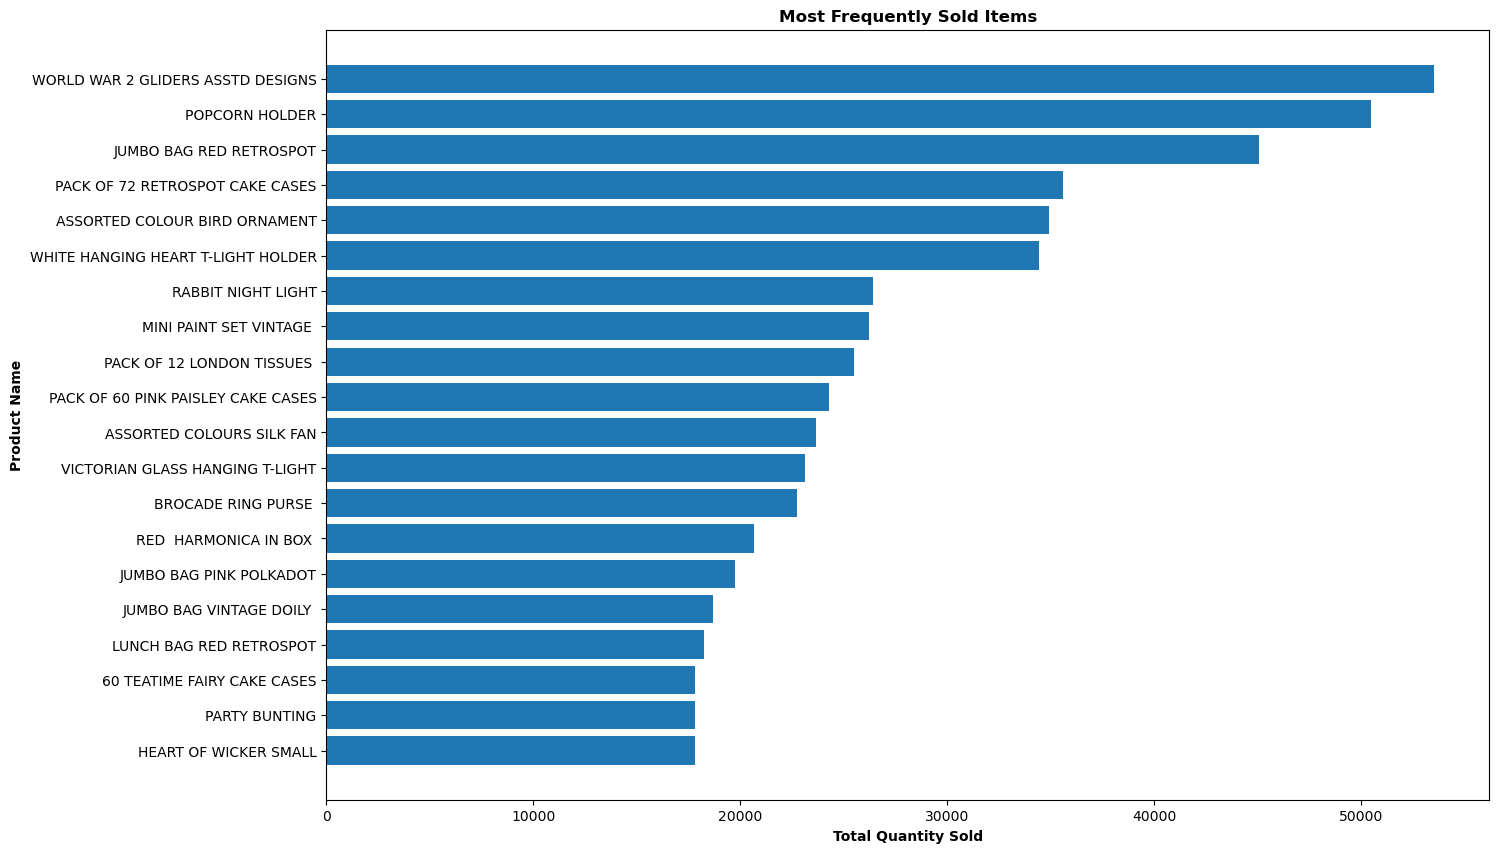

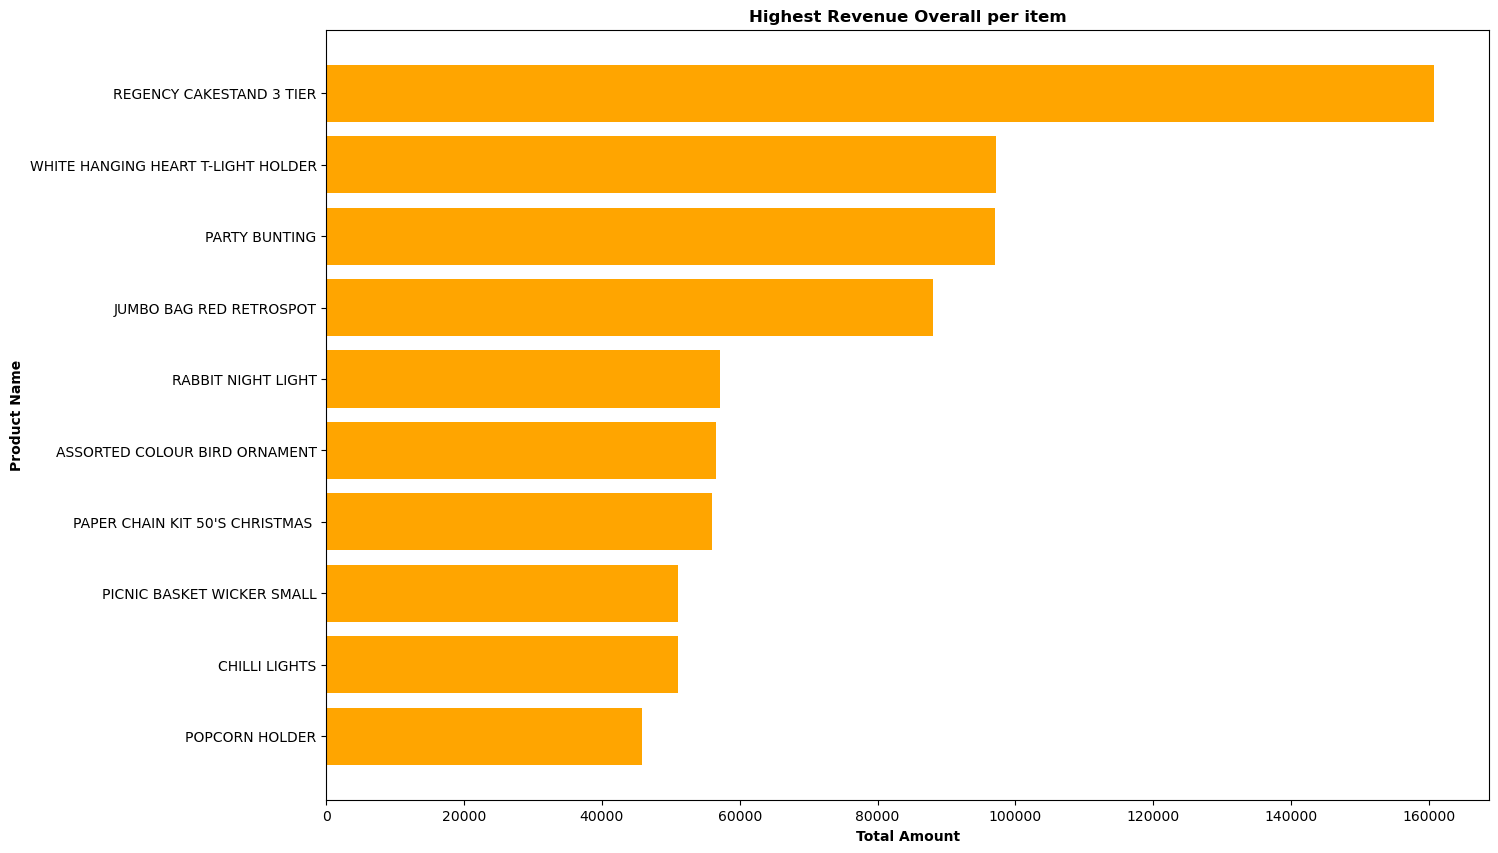

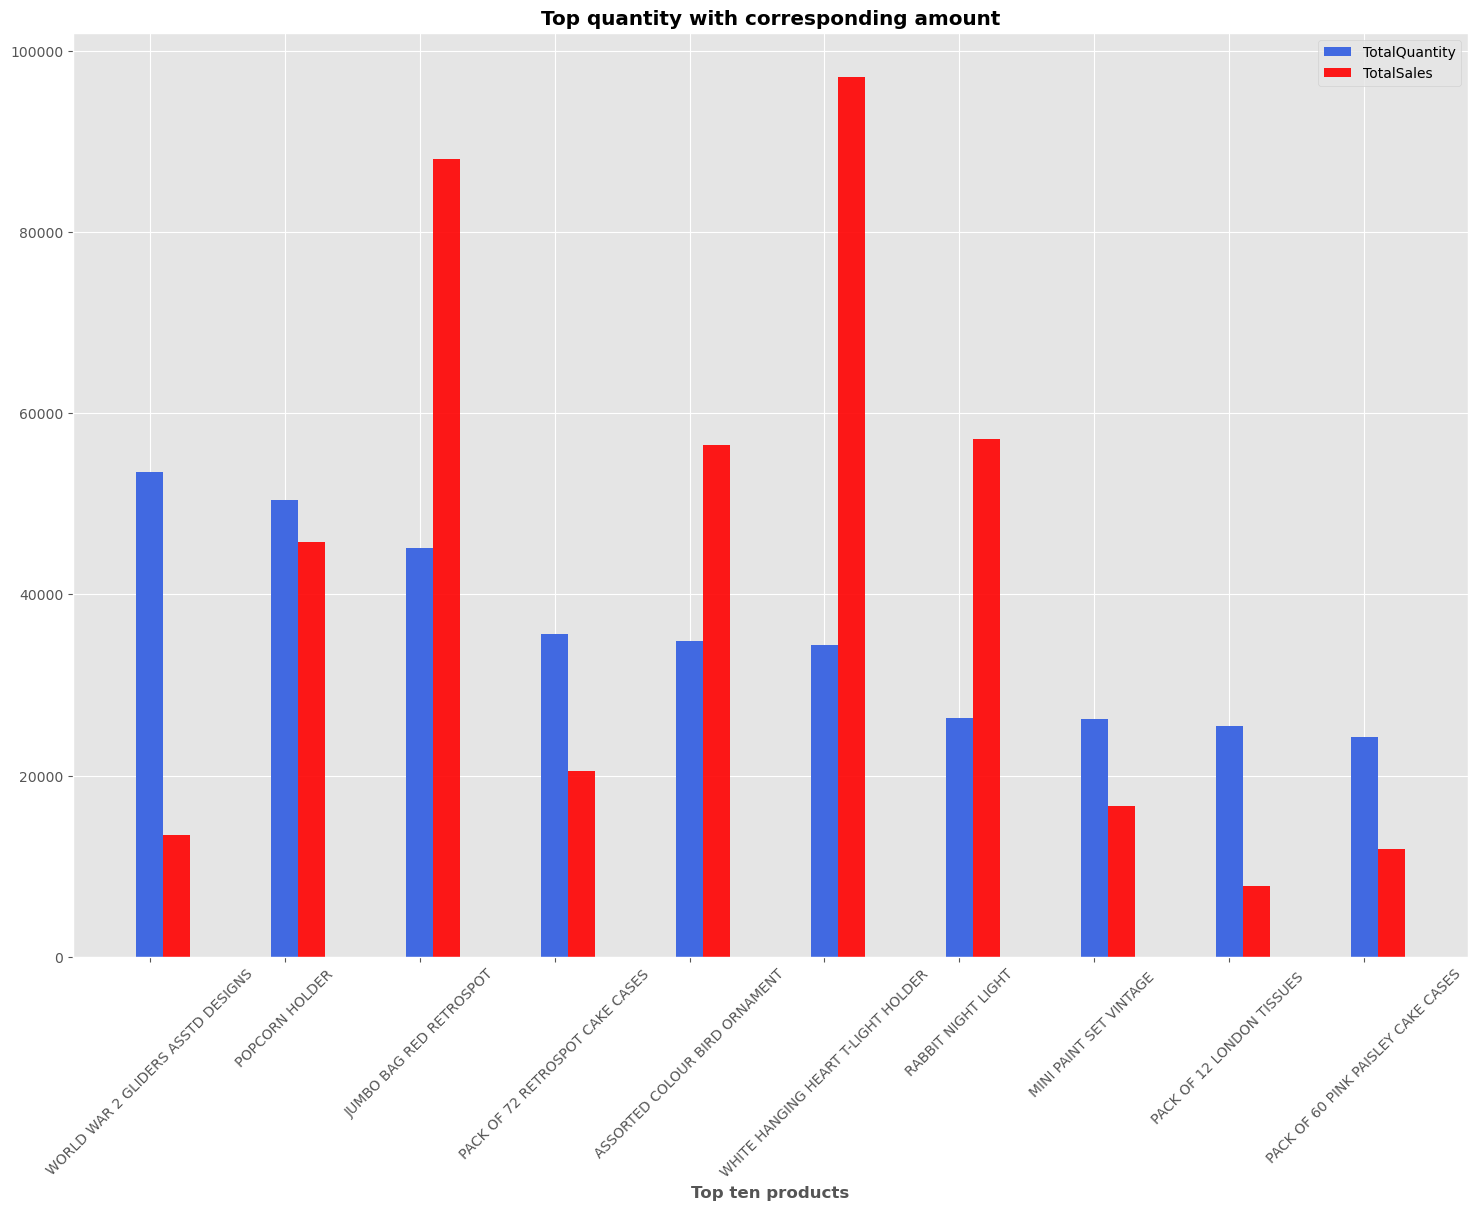

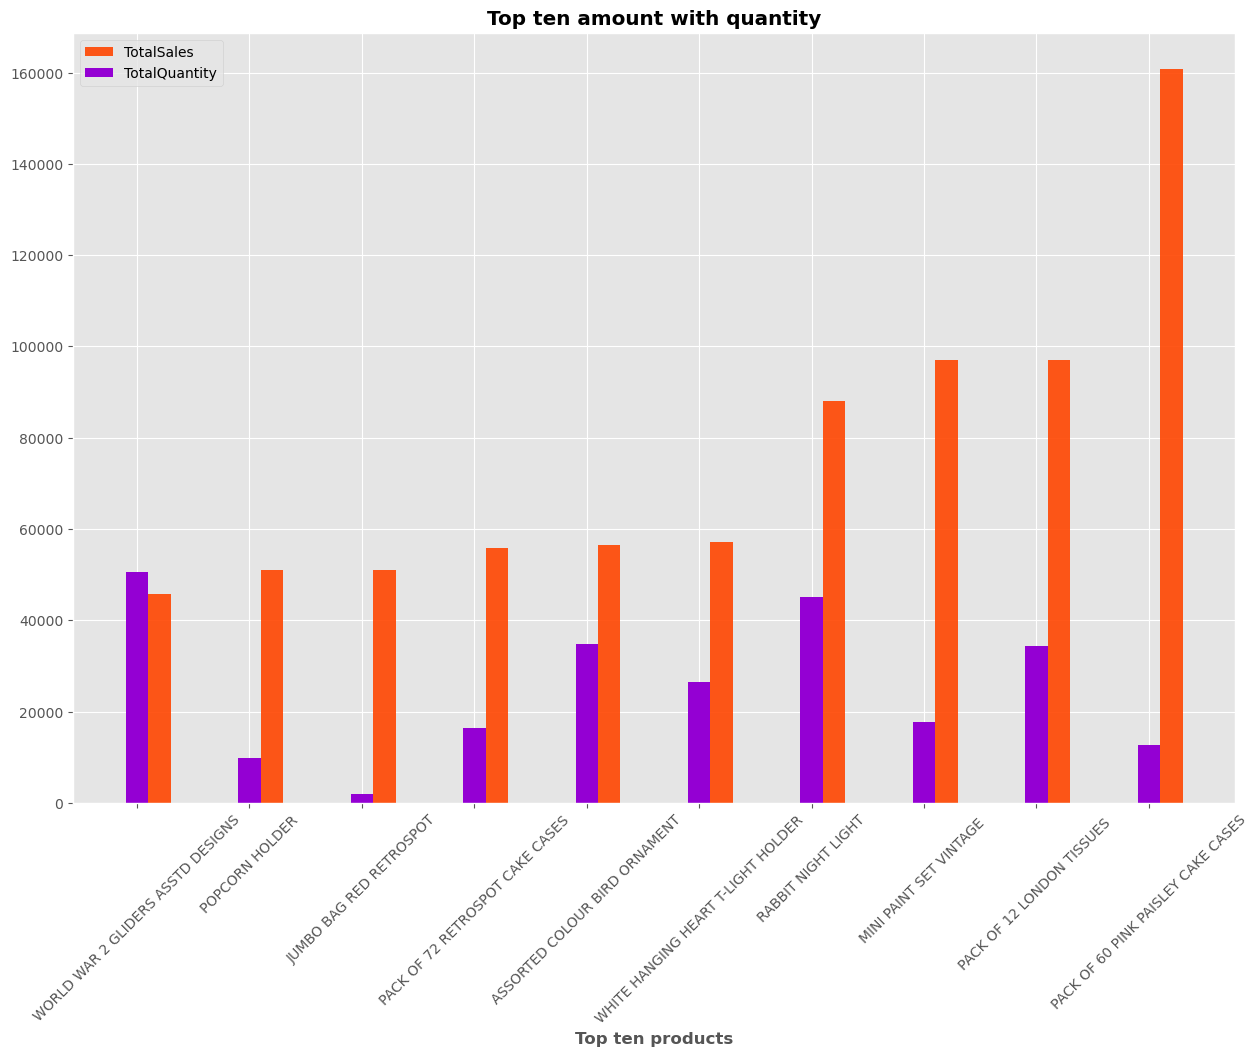

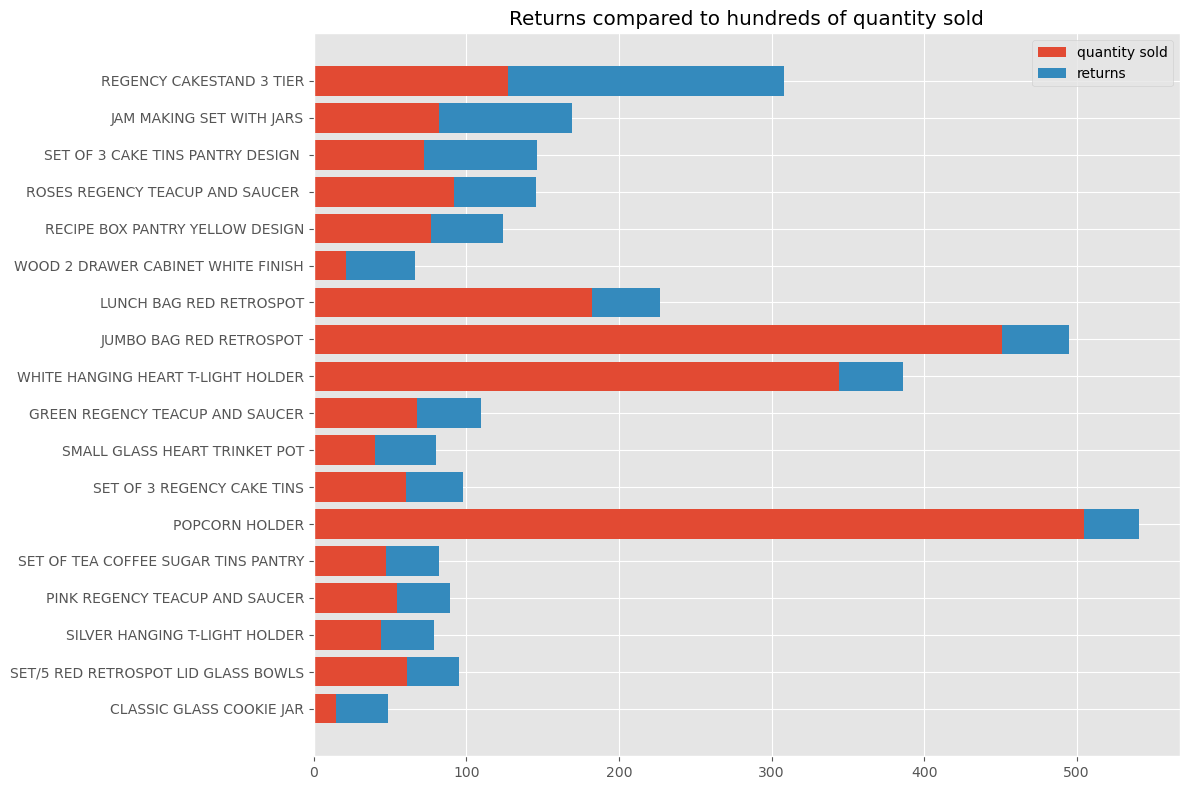

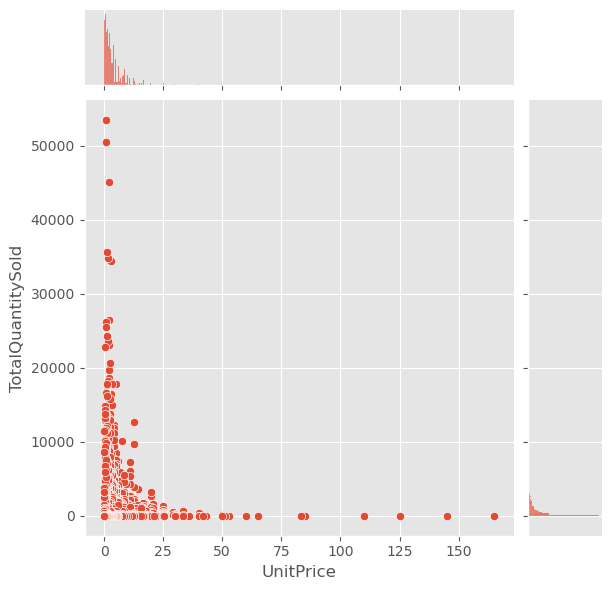

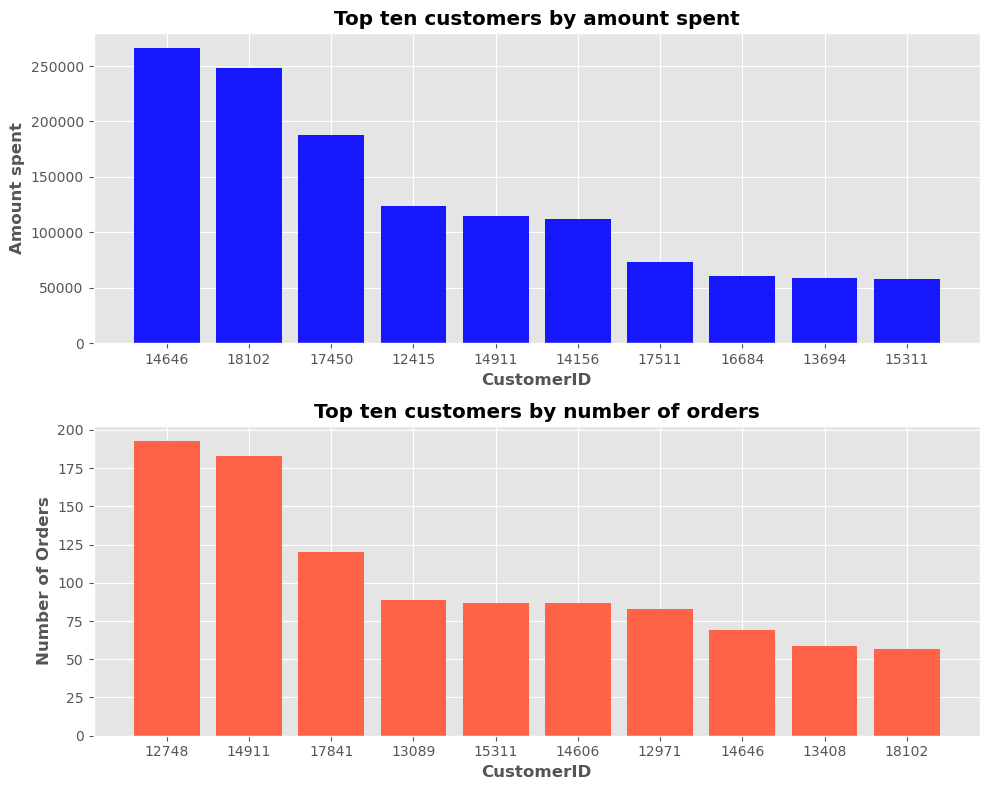

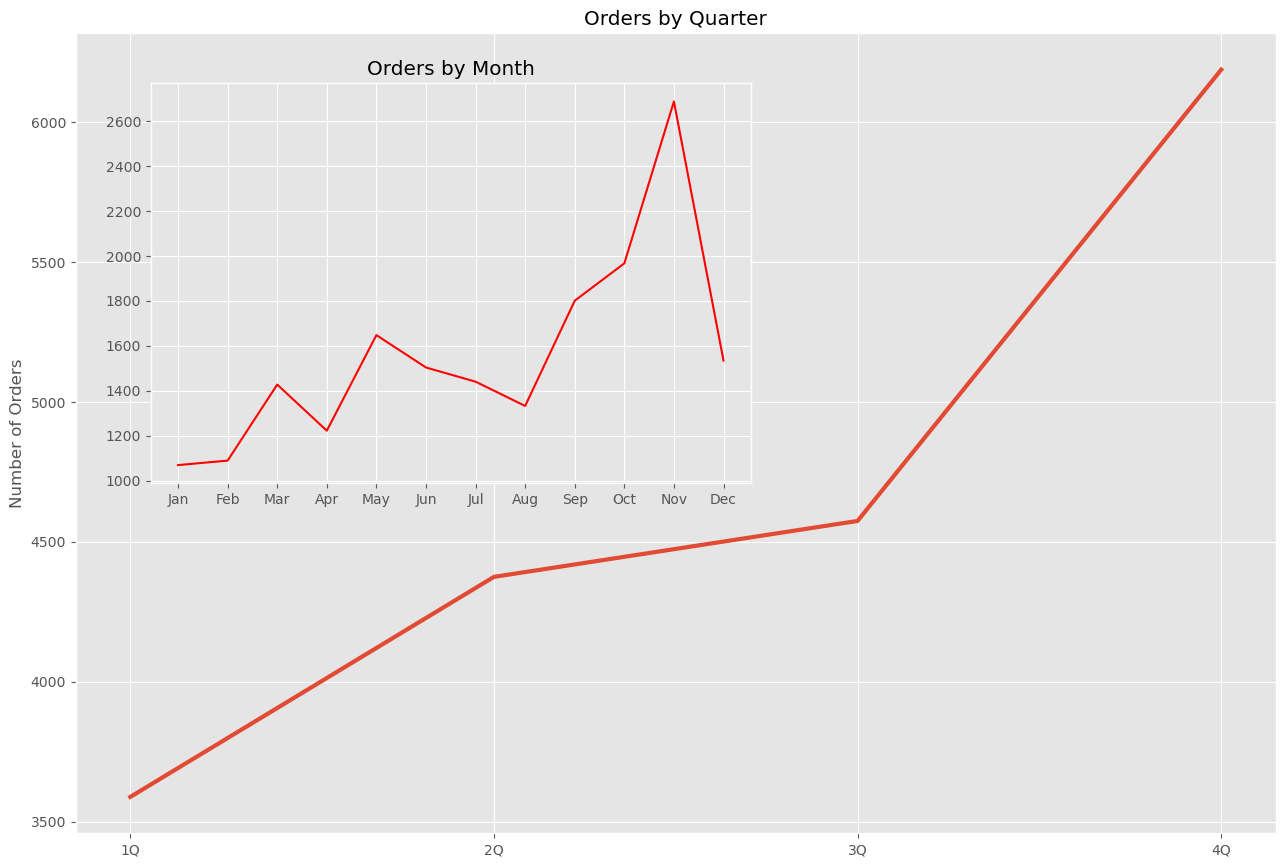

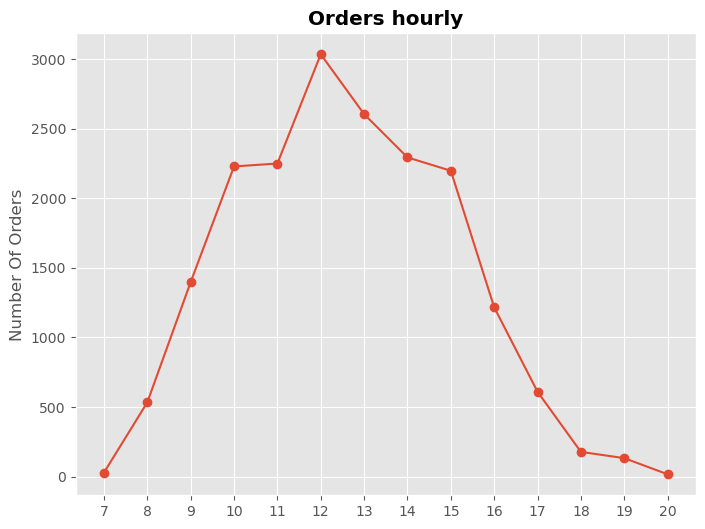

In [4]:
# charts 

 #ITEMS
#top ten quantity
fig = plt.figure(figsize=(15,10))
plt.barh(y=top_20_most_frequently_sold_items["Description"],width=top_20_most_frequently_sold_items["TotalQuantitySold"])
plt.xlabel('Total Quantity Sold',fontweight='bold')
plt.ylabel('Product Name',fontweight='bold')
plt.title('Most Frequently Sold Items',fontweight='bold')
plt.savefig('Most_Freq_Items_Sold.png',bbox_inches='tight')

#top ten total price
fig = plt.figure(figsize=(15,10))
plt.barh(y=top_10_total_amount_items["Description"],width=top_10_total_amount_items["TotalPrice"],color=['orange'])
plt.xlabel('Total Amount',fontweight='bold')
plt.ylabel('Product Name',fontweight='bold')
plt.title('Highest Revenue Overall per item',fontweight='bold')
plt.savefig('Items_with_highest_total_price.png',bbox_inches='tight')

#top ten quantity with total_sales
style.use('ggplot')
xpos = np.arange(len(most_frequently_sold_items['Description'][:10]))
barwidth=0.2
plt.figure(figsize=(18,12))
plt.bar(xpos, most_frequently_sold_items['TotalQuantitySold'][:10], width=barwidth,color='royalblue',label='TotalQuantity')
plt.bar(xpos +0.2, most_frequently_sold_items['TotalPrice'][:10],width=barwidth,color='red',label='TotalSales',alpha=0.9)
plt.xticks(xpos,([name for name in most_frequently_sold_items['Description'][:10]]),rotation=45)
plt.title('Top quantity with corresponding amount',fontweight='bold')
plt.legend()
plt.xlabel('Top ten products',fontweight='bold')
plt.savefig('Quantity_with_total_sales.png',bbox_inches='tight')

#top ten amount with quantity
style.use('ggplot')
xpos = np.arange(len(top_10_total_amount_items['Description'][:10]))
barwidth=0.2
plt.figure(figsize=(15,10))
plt.bar(xpos +0.2, top_10_total_amount_items['TotalPrice'][:10],width=barwidth,color='orangered',label='TotalSales',alpha=0.9)
plt.bar(xpos, top_10_total_amount_items['TotalQuantitySold'][:10], width=barwidth,color='darkviolet',label='TotalQuantity')
plt.xticks(xpos,([name for name in most_frequently_sold_items['Description'][:10]]),rotation=45)
plt.title('Top ten amount with quantity',fontweight='bold')
plt.legend()
plt.xlabel('Top ten products',fontweight='bold')
plt.savefig('Top_amount_with_quantity.png',bbox_inches='tight')

# top returned items
return_names = [name for name 
                 in cancelled_orders_and_returns.groupby('Description')['StockCode'].count()
                 .sort_values(ascending=False)[:21].index]
number_of_returns = [value for value in cancelled_orders_and_returns.groupby('Description')['StockCode'].count()
                 .sort_values(ascending=False)[:21].values]
returns_with_names = pd.DataFrame({'Description':return_names,
                                        'NumberOfReturns':number_of_returns})
# deleting samples because they are not returns 
del return_names[3]
del number_of_returns[3]

prices_of_most_returned_items = product_summary[product_summary['Description'].isin(return_names)]
merged_df = prices_of_most_returned_items.merge(returns_with_names,on='Description',how='left')
merged_df = merged_df.sort_values(by='NumberOfReturns',ascending=False)
merged_df = merged_df.reset_index(drop=True).drop(df.index[10])
merged_df

desc_names = [name for name in merged_df['Description'].values[::-1]]
returns_list = [num for num in merged_df['NumberOfReturns'].values[::-1]]
total_sold = [(num/100) for num in merged_df['TotalQuantitySold'][::-1]]
plt.figure(figsize=(12,8))
plt.barh(desc_names,total_sold,label='quantity sold')
plt.barh(desc_names,returns_list, left=total_sold, label='returns')
plt.title('Returns compared to hundreds of quantity sold')
plt.legend()
plt.tight_layout()
plt.savefig('Stacked_returns_chart.png')

# distribution quantity and price 
sns.jointplot(x='UnitPrice',y='TotalQuantitySold',data=product_summary)
plt.savefig('Distribution_prices_over_quantity',bbox_inches='tight')

 #CUSTOMERS
# top ten customers by orders

unique_customers = unique_orders['CustomerID'].value_counts()
top_10_customers_by_orders = unique_orders['CustomerID'].value_counts()[1:11]
values = [str(value) for value in top_10_customers_by_orders.index]

# top ten customers by amount spent
customers_by_amount_spent = unique_orders.groupby('CustomerID')['FullPrice'].sum().sort_values(ascending=False)
top_10_customers_by_amount_spent = customers_by_amount_spent[1:11]
amount_spent_customer_IDs = [str(value) for value in top_10_customers_by_amount_spent.index]

fig, axs = plt.subplots(2,1,figsize=(10,8))
axs[0].bar(x=amount_spent_customer_IDs,height = top_10_customers_by_amount_spent.values,color='blue',alpha=0.9)
axs[0].set_title('Top ten customers by amount spent',fontweight='bold')
axs[0].set_xlabel('CustomerID',fontweight='bold')
axs[0].set_ylabel('Amount spent',fontweight='bold')

axs[1].bar(x=values,height= top_10_customers_by_orders.values,color='tomato')
axs[1].set_title('Top ten customers by number of orders',fontweight='bold')
axs[1].set_xlabel('CustomerID',fontweight='bold')
axs[1].set_ylabel('Number of Orders',fontweight='bold')
plt.tight_layout()

fig.savefig('Top_ten_customers.png')

 #orders by time 
# quarterly and monthly
fig = plt.figure(figsize=(15,10))
axes1=fig.add_axes([0,0.1,0.8,0.8])
axes1.plot(unique_orders.groupby('quarter')['Quantity'].count(),lw=3)
plt.title('Orders by Quarter')
plt.ylabel('Number of Orders')
plt.xticks(np.arange(1,5),['1Q','2Q','3Q','4Q'])
axes2 = fig.add_axes([0.05,0.45,0.4,0.4])
axes2.plot(unique_orders.groupby('month')['Quantity'].count(),color='red')
plt.title('Orders by Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.savefig('Orders_quarterly_monthly.png',bbox_inches='tight')

#hourly
hours = [hour for hour in unique_orders.groupby('hour')['Quantity'].count().index]
orders_per_hour = [num for num in unique_orders.groupby('hour')['Quantity'].count().values]

plt.figure(figsize=(8,6))
plt.plot(hours,orders_per_hour,marker='o')
plt.xticks(hours)
plt.title('Orders hourly',fontweight='bold')
plt.ylabel('Number Of Orders')
plt.savefig('Orders_hourly.png')




In [8]:
# countries which buy the most 

def create_country_orders_tuples(orders):
    country_order_counts = orders['Country'].value_counts()
    country_order_tuples = [(country, count) for country, count in country_order_counts.items() if (country !='Unspecified') and (country!= 'Channel Islands')]
    return country_order_tuples

def map_countries_with_codes(country_order_tuples):

    country_codes = {
        'United Kingdom': 'gb',
        'Germany': 'de',
        'France': 'fr',
        'EIRE': 'ie',
        'Spain': 'es',
        'Netherlands': 'nl',
        'Belgium': 'be',
        'Switzerland': 'ch',
        'Portugal': 'pt',
        'Australia': 'au',
        'Norway': 'no',
        'Italy': 'it',
        'Finland': 'fi',
        'Cyprus': 'cy',
        'Sweden': 'se',
        'Austria': 'at',
        'Denmark': 'dk',
        'Japan': 'jp',
        'Poland': 'pl',
        'Israel': 'il',
        'USA': 'us',
        'Hong Kong': 'hk',
        'Singapore': 'sg',
        'Iceland': 'is',
        'Canada': 'ca',
        'Greece': 'gr',
        'Malta': 'mt',
        'United Arab Emirates': 'ae',
        'European Community': 'eu',
        'RSA': 'za',
        'Lebanon': 'lb',
        'Lithuania': 'lt',
        'Brazil': 'br',
        'Czech Republic': 'cz',
        'Bahrain': 'bh',
        'Saudi Arabia': 'sa'
    }   
    country_order_tuples_with_codes = [
        (country_codes.get(country, country), order) for country, order in country_order_tuples
    ]  
    return country_order_tuples_with_codes

def create_interactive_map_and_save_as_file(countries,name):
    worldmap_chart = World()
    worldmap_chart.title = 'Number of orders based on Country'
    worldmap_chart.add('In 2010-2011',countries)
    worldmap_chart.render_to_file(name)

from pygal_maps_world.maps import World

# order-based
unsepcifed_country_orders = [('unspecified',13)]
channel_islands_orders = [('Channel Islands',24)]
uk_orders = ['UK',16961]
country_order_tuples = create_country_orders_tuples(unique_orders)
country_order_tuples_with_codes = map_countries_with_codes(country_order_tuples)
country_order_tuples_with_codes.pop(0)

create_interactive_map_and_save_as_file(country_order_tuples_with_codes,'countries_orders_map.svg')

In [113]:
# total sales compared to returns 
sales_minus_returns_amount = product_summary['TotalPrice'].sum() - cancelled_orders_and_returns['FullPrice'].sum()
total_sales_amount = product_summary['TotalPrice'].sum()


In [32]:
#unique_orders_for_customer
unique_orders.groupby('CustomerID')['InvoiceNo'].count().value_counts()

1       1551
2        807
3        510
4        386
5        223
6        168
7        131
8         93
9         60
11        51
10        47
12        40
13        26
14        21
15        20
19        16
17        15
16        13
20        11
18        10
21         9
23         7
25         6
28         6
26         5
27         4
24         4
37         3
22         3
30         3
35         3
29         2
43         2
55         2
47         2
87         2
32         2
34         2
50         1
31         1
44         1
39         1
183        1
120        1
1321       1
69         1
53         1
54         1
36         1
45         1
59         1
89         1
83         1
193        1
57         1
Name: InvoiceNo, dtype: int64

In [10]:
grouped_by_customer = unique_orders.groupby('CustomerID')

In [13]:
grouped_by_customer
average_order_size_per_customer = grouped_by_customer['Quantity'].mean()


In [12]:
average_order_size_per_customer.sort_values().mean()

228.77749094904792

In [14]:
average_order_size_per_customer

CustomerID
0        295.029523
12347    377.666667
12348    583.000000
12349    630.000000
12350    196.000000
            ...    
18280     45.000000
18281     54.000000
18282     75.000000
18283     83.533333
18287    528.666667
Name: Quantity, Length: 4283, dtype: float64

In [116]:
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = True
    else:
        res = False
    return res

df2 = pd.crosstab(orders['InvoiceNo'],orders['StockCode']) 
basket_input = df2.applymap(encode)

In [121]:
#market basket analysis using FP-growth algorithm
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = True
    else:
        res = False
    return res

df2 = pd.crosstab(orders['InvoiceNo'],orders['StockCode']) 
basket_input = df2.applymap(encode)

def create_pivot_for_country(country_df):
    df2 = pd.crosstab(country_df['InvoiceNo'],country_df['StockCode']) 
    country_basket =  df2.applymap(encode)
    return country_basket

from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

germany_df = orders[orders['Country']=='Germany']
germany_basket = create_pivot_for_country(germany_df)
frequent_itemsets_germany = fpgrowth(germany_basket, min_support=0.005, use_colnames=True)
rules = association_rules(frequent_itemsets_germany, metric="lift")

rules.head()

uk_df = orders[orders['Country']=='United Kingdom']
uk_basket = create_pivot_for_country(uk_df)
frequent_itemsets_uk = fpgrowth(uk_basket, min_support=0.005, use_colnames=True)
rules = association_rules(frequent_itemsets_uk, metric="lift")

rules.head()

In [3]:
unique_orders

,InvoiceNo,Country,DiffrentItemsPerOrder,Quantity,CustomerID,InvoiceDate,FullPrice,hour,quarter,month,dayofweek
0,536365,United Kingdom,7,40,17850,2010-12-01 08:26:00,139.12,8,4,12,2
1,536366,United Kingdom,1,6,17850,2010-12-01 08:28:00,11.10,8,4,12,2
2,536367,United Kingdom,12,83,13047,2010-12-01 08:34:00,278.73,8,4,12,2
3,536368,United Kingdom,4,15,13047,2010-12-01 08:34:00,70.05,8,4,12,2
4,536369,United Kingdom,1,3,13047,2010-12-01 08:35:00,17.85,8,4,12,2
...,...,...,...,...,...,...,...,...,...,...,...
18722,579868,United Kingdom,22,406,15544,2011-11-30 13:45:00,328.32,13,4,11,2
18723,579870,France,13,97,12437,2011-11-30 13:46:00,256.41,13,4,11,2
18724,579872,United Kingdom,17,239,14085,2011-11-30 13:48:00,278.82,13,4,11,2
18725,579881,Denmark,27,512,12429,2011-11-30 13:50:00,905.52,13,4,11,2


In [6]:
unique_orders[unique_orders['Country']=='France']

,InvoiceNo,Country,DiffrentItemsPerOrder,Quantity,CustomerID,InvoiceDate,FullPrice,hour,quarter,month,dayofweek
5,536370,France,19,446,12583,2010-12-01 08:45:00,801.86,8,4,12,2
272,536852,France,6,106,12686,2010-12-03 09:49:00,71.14,9,4,12,4
308,536974,France,15,130,12682,2010-12-03 13:43:00,300.24,13,4,12,4
356,537065,France,62,602,12567,2010-12-05 11:54:00,1364.92,11,4,12,6
533,537463,France,40,581,12681,2010-12-07 10:06:00,961.52,10,4,12,1
...,...,...,...,...,...,...,...,...,...,...,...
18627,579529,France,26,267,12488,2011-11-29 14:53:00,477.21,14,4,11,1
18665,579634,France,11,147,12598,2011-11-30 08:23:00,163.85,8,4,11,2
18689,579708,France,18,236,12682,2011-11-30 10:49:00,434.96,10,4,11,2
18710,579792,France,67,806,12714,2011-11-30 12:32:00,1229.16,12,4,11,2


<AxesSubplot:xlabel='Quantity', ylabel='Density'>

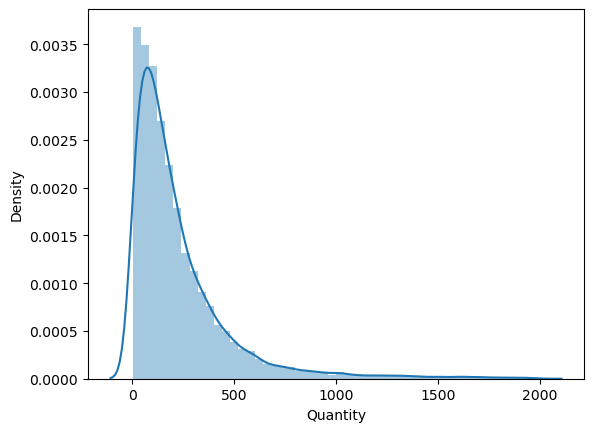

In [11]:
sns.distplot(unique_orders[unique_orders['Quantity']<2000]['Quantity'])

# Clustering 

In [20]:
from sklearn.cluster import KMeans

In [168]:
clustering1 = KMeans(n_clusters=6)

In [22]:
grouped_by_customer = unique_orders.groupby('CustomerID')

In [33]:
grouped_by_customer['Quantity'].mean('DiffrentItemsPerOrder').values/grouped_by_customer['InvoiceNo'].count().values

array([  0.22333802,  62.94444444, 145.75      , ...,  75.        ,
         5.56888889, 176.22222222])

In [36]:
grouped_by_customer['InvoiceNo'].count()[1:]

CustomerID
12347     6
12348     4
12349     1
12350     1
12352     5
         ..
18280     1
18281     1
18282     1
18283    15
18287     3
Name: InvoiceNo, Length: 4282, dtype: int64

In [40]:
len(grouped_by_customer['InvoiceNo'].count().values[1:])

4282

In [47]:
mean_order_size = grouped_by_customer['Quantity'].mean('DiffrentItemsPerOrder')[1:]/grouped_by_customer['InvoiceNo'].count().values[1:]

In [41]:
len(grouped_by_customer['Quantity'].mean('DiffrentItemsPerOrder'))

4283

In [70]:
mean_order_size.describe()

count    4282.000000
mean      122.913372
std       249.687840
min         0.368179
25%        29.212500
50%        64.000000
75%       136.437500
max      7824.000000
Name: Quantity, dtype: float64

In [109]:
sorted_by_customer = unique_orders.sort_values(by=['CustomerID']) 
sorted_by_customer = sorted_by_customer[sorted_by_customer['CustomerID']!=0]

In [75]:
sorted_by_customer['mean_order_size'] = mean_order_size

In [110]:
sorted_by_customer

,InvoiceNo,Country,DiffrentItemsPerOrder,Quantity,CustomerID,InvoiceDate,FullPrice,hour,quarter,month,dayofweek
576,537626,Iceland,31,319,12347,2010-12-07 14:57:00,711.79,14,4,12,1
15962,573511,Iceland,47,676,12347,2011-10-30 15:57:00,1294.32,15,4,10,6
2406,542237,Iceland,29,315,12347,2011-01-26 13:37:00,475.39,13,1,1,2
8427,556201,Iceland,18,196,12347,2011-06-09 09:39:00,382.52,9,2,6,3
10943,562032,Iceland,22,277,12347,2011-08-01 10:09:00,584.91,10,3,8,0
...,...,...,...,...,...,...,...,...,...,...,...
9176,557956,United Kingdom,87,157,18283,2011-06-23 13:13:00,203.81,13,2,6,3
16849,575668,United Kingdom,59,64,18283,2011-11-10 12:13:00,112.35,12,4,11,3
14738,570715,United Kingdom,38,990,18287,2011-10-11 14:19:00,1001.32,14,4,10,1
15776,573167,United Kingdom,3,108,18287,2011-10-27 16:24:00,70.68,16,4,10,3


In [89]:
index = [value for value in mean_order_size.index]

In [91]:
hook = 0
for row in mean_order_size:
    row = [row,index[hook]]
    hook+=1

In [95]:
frame = {
    'InvoiceNum':index,
    'mean_order_size':mean_order_size.values
}

,InvoiceNo,mean_order_size
0,12347,62.944444
1,12348,145.750000
2,12349,630.000000
3,12350,196.000000
4,12352,15.520000
...,...,...
4277,18280,45.000000
4278,18281,54.000000
4279,18282,75.000000
4280,18283,5.568889


In [103]:
df2 = pd.DataFrame(frame)

In [112]:
df2.rename(columns={'InvoiceNo':'CustomerID'},inplace=True)

In [116]:
sorted_by_customer = sorted_by_customer.merge(df2[['CustomerID', 'mean_order_size']])


In [99]:
num_of_orders = sorted_by_customer.groupby('CustomerID')['InvoiceNo'].count()

In [187]:
df2['Amount_Spent_per_order'] = df2['Amount_Spent']/df2['num_of_orders']

In [188]:
df2

,CustomerID,mean_order_size,order_size_clusters,num_of_orders,Amount_Spent,Amount_Spent_clusters,Amount_Spent_per_order
0,12347,62.944444,0,6,4085.18,5,680.863333
1,12348,145.750000,7,4,1437.24,0,359.310000
2,12349,630.000000,2,1,1457.55,0,1457.550000
3,12350,196.000000,7,1,294.40,0,294.400000
4,12352,15.520000,0,5,1125.28,0,225.056000
...,...,...,...,...,...,...,...
4277,18280,45.000000,0,1,180.60,0,180.600000
4278,18281,54.000000,0,1,80.82,0,80.820000
4279,18282,75.000000,0,1,100.21,0,100.210000
4280,18283,5.568889,0,15,1880.93,0,125.395333


In [133]:
sorted_by_customer.groupby('CustomerID')['FullPrice'].sum()

CustomerID
12347    4085.18
12348    1437.24
12349    1457.55
12350     294.40
12352    1125.28
          ...   
18280     180.60
18281      80.82
18282     100.21
18283    1880.93
18287    1837.28
Name: FullPrice, Length: 4282, dtype: float64

In [136]:
df2['num_of_orders'] = num_of_orders.values
df2['Amount_Spent'] = sorted_by_customer.groupby('CustomerID')['FullPrice'].sum().values

In [164]:
clustering1.fit(df2[['mean_order_size']]) 
df2

,CustomerID,mean_order_size,order_size_clusters,num_of_orders,Amount_Spent,Amount_Spent_clusters
0,12347,62.944444,0,6,4085.18,0
1,12348,145.750000,7,4,1437.24,3
2,12349,630.000000,2,1,1457.55,3
3,12350,196.000000,7,1,294.40,3
4,12352,15.520000,0,5,1125.28,3
...,...,...,...,...,...,...
4277,18280,45.000000,0,1,180.60,3
4278,18281,54.000000,0,1,80.82,3
4279,18282,75.000000,0,1,100.21,3
4280,18283,5.568889,0,15,1880.93,3


In [169]:
clustering1.fit(df2[['Amount_Spent']])
df2['Amount_Spent_clusters'] = clustering1.labels_

In [170]:
df2['Amount_Spent_clusters'].value_counts()

0    3641
5     549
4      67
3      19
2       3
1       3
Name: Amount_Spent_clusters, dtype: int64

In [ ]:
df2

In [124]:
df2['order_size_clusters'] = clustering1.labels_

In [174]:
clustering1.inertia_

10444255918.518616

In [189]:
inertia_scores = []

for i in range(1,11):
    clustering1 = KMeans(n_clusters=i)
    clustering1.fit(df2[['Amount_Spent_per_order']])
    inertia_scores.append(clustering1.inertia_)

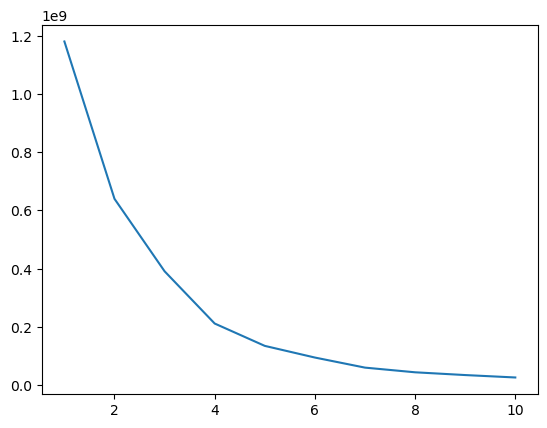

In [191]:
plt.plot(range(1,11), inertia_scores)

In [193]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df2[['Amount_Spent_per_order']])

KMeans(n_clusters=4)

In [194]:
df2['Amount_per_order_clusters'] = kmeans.labels_

In [196]:
df2['Amount_per_order_clusters'].value_counts()

0    3886
3     377
1      18
2       1
Name: Amount_per_order_clusters, dtype: int64

In [203]:
df2[df2['Amount_per_order_clusters']==2]['Amount_Spent_per_order'].max()

19809.75